![Colegio Bourbaki](./Images/Bourbaki.png)

## Rudimentos de Machine Learning

### Introducción a los Encajes en BERT para la Vectorización de Textos

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de aprendizaje profundo desarrollado por Google para procesar y entender el lenguaje natural. A diferencia de los modelos tradicionales de procesamiento de texto que analizan las oraciones de manera secuencial (izquierda a derecha o viceversa), BERT utiliza un enfoque bidireccional, lo que le permite considerar el contexto completo de una palabra tanto desde la izquierda como desde la derecha.

Vectorización de Textos con BERT:

* Preprocesamiento del Texto: Antes de que BERT procese el texto, es necesario tokenizarlo. Esto significa convertir el texto en una lista de tokens, que son las unidades básicas que BERT entiende. Además, se agregan tokens especiales como [CLS] (inicio del texto) y [SEP] (separador).

* Generación de Encajes (Embeddings): Una vez tokenizado el texto, BERT transforma cada token en un vector de alta dimensión. Estos vectores, conocidos como encajes o embeddings, representan la información semántica y contextual de los tokens en el espacio vectorial.

* Vectorización del Texto: La vectorización es el proceso de convertir el texto en una representación numérica que los algoritmos de machine learning pueden procesar. BERT produce vectores de alta calidad que capturan no solo el significado individual de las palabras, sino también su contexto en la oración.

* Uso de los Encajes: Los vectores generados por BERT se pueden utilizar para diversas tareas de procesamiento de lenguaje natural, como clasificación de texto, análisis de sentimientos, búsqueda de información y más. Estos vectores se alimentan en modelos de machine learning para realizar predicciones basadas en el texto.

En resumen, BERT mejora significativamente la vectorización de textos al proporcionar una representación rica y contextual de las palabras, permitiendo una comprensión más profunda y precisa del lenguaje natural.

**En este notebook, nos centraremos en los discursos presidenciales del ex-presidente de Argentina, Alberto Fernández durante el período 2019-2023**

**NOTA: No explicaremos cómo funciona BERT ni su arquitectura, nos centraremos en obtener vectorización de textos. Esto signifca que vamos a representar la información pero de manera distinta. En vez de ver texto, observaremos una representación vectorial del mismo**

### Librerías

In [1]:
# Procesamiento y Visualizacion de Datos
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

# Preprocesar texto
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Encajes
from transformers import BertTokenizer, BertModel
import torch

#Utils
import glob
import re
from collections import Counter

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdconte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!python3 -m spacy download es_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 25.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [4]:
stopwords_nltk = stopwords.words("spanish")
len(stopwords_nltk)

313

In [5]:
stopwords = pd.read_csv(
    "https://gist.githubusercontent.com/cr0wg4n/78554c5d0afa9944d2fa3a4435d83a57/raw/df59fb916108f2a58bf1a3d8c62818b44231586d/spanish-stop-words.txt",
    header=None,
)
stopwords_list = stopwords[0].tolist()
len(stopwords_list)

608

### Funciones de ayuda

In [6]:
def generate_wordcloud(sequence):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sequence)

    # Crear la nube de palabras
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        normalize_plurals=False,
        collocations=False,
    ).generate(text)

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [7]:
nlp = spacy.load("es_core_news_sm")

In [8]:
def preprocesar(text):
    #Convierte a minúsculas
    text = text.lower()

    # Elimina stopwords
    stop = re.compile(r"\b(" + r"|".join(stopwords_list) + r")\b\s*")
    text = stop.sub("", text)

    # Quitar puntuación y números
    text = re.sub("[^ña-záéíóúü]+", " ", text)

    # Lematizar y quedarnos con palabras que tengan más de tres caracteres
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token) > 2])
    return text

In [9]:
def vectorize_text(text):
    # Tokenizar el texto y convertirlo en tensores de PyTorch
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Pasar los tensores por el modelo BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Usar la salida de la capa oculta como el encaje del texto
    # Aquí tomamos la salida del token [CLS], que representa el significado de la secuencia entera
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return embeddings

### Carga de datos

Primero leeremos todos los archivos de texto correspondiente a los discursos presidenciales del ex presidente Alberto Fernández.

Si desean hacerlos desde localhost:

In [10]:
speech_list = glob.glob("./Data/AF/*.txt")

df_af = pd.DataFrame(
    columns=["speech", "date", "speech_length"],
    index=[i for i in range(len(speech_list))],
)

In [11]:
date_pattern = re.compile(r"(\d{2})_(\d{2})_(\d{4})")

for key, speech in enumerate(speech_list):
    with open(speech, "r", encoding="utf-8") as file:
        df_af.loc[key, "speech"] = file.read()
    match = date_pattern.search(speech)
    if match:
    # Extract date components from the matched groups
        month = match.group(1)
        day = match.group(2)
        year = match.group(3)
    # Format the date components as MM/DD/YYYY
        formatted_date = f"{month}/{day}/{year}"
    df_af.loc[key, "date"] = formatted_date
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("(APLAUSOS)", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("(APLAUSO)", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PRESIDENTE FERNANDEZ.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("FERNANDEZ.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PRESIDENTE.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PERIODISTA.-", "")
    df_af.loc[key, "speech_length"] = len(df_af["speech"][key].split())

Pueden hacer web scrapping si así lo desean también. 

In [12]:
df_af

,speech,date,speech_length
0,Gracias a todos y a todas; gracias María Eugen...,05/14/2020,1592
1,Buenas tardes Señor Presidente.\n\nEl mundo es...,09/19/2023,2359
2,"Buenas tardes a todos y a todas, gracias por i...",08/30/2021,941
3,"Buenas tardes a todos y todas, muchas gracias,...",08/10/2022,1788
4,"Muy bien, muchas gracias querida La Rioja, sie...",06/13/2020,1611
...,...,...,...
660,"Muy bien, buen día para todos y todas. Gracias...",08/19/2020,1452
661,Buenos días a todos y a todas. Gracias a todos...,10/24/2022,2644
662,Muchas gracias. Buen día a todos y todas. Muy ...,06/09/2023,951
663,"Gracias, gracias a todos y a todas, de verdad ...",05/29/2020,1066


In [13]:
# Dtypes assignment
df_af["speech"] = df_af["speech"].astype(str)
df_af["date"] = pd.to_datetime(df_af["date"], errors='coerce') 
df_af["speech_length"] = df_af["speech_length"].astype(int)

In [14]:
df_af

,speech,date,speech_length
0,Gracias a todos y a todas; gracias María Eugen...,2020-05-14,1592
1,Buenas tardes Señor Presidente.\n\nEl mundo es...,2023-09-19,2359
2,"Buenas tardes a todos y a todas, gracias por i...",2021-08-30,941
3,"Buenas tardes a todos y todas, muchas gracias,...",2022-08-10,1788
4,"Muy bien, muchas gracias querida La Rioja, sie...",2020-06-13,1611
...,...,...,...
660,"Muy bien, buen día para todos y todas. Gracias...",2020-08-19,1452
661,Buenos días a todos y a todas. Gracias a todos...,2022-10-24,2644
662,Muchas gracias. Buen día a todos y todas. Muy ...,2023-06-09,951
663,"Gracias, gracias a todos y a todas, de verdad ...",2020-05-29,1066


In [15]:
# Sorting by date
df_af = df_af.sort_values("date")

In [16]:
df_af

,speech,date,speech_length
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233
...,...,...,...
632,"Bueno, antes que nada, buenos días: bienvenido...",2023-10-06,127
146,Señor presidente de la República Popular China...,2023-10-18,1079
260,"Buen día a todos y todas, gracias por estar a...",2023-11-19,159
262,"Señor presidente; querido amigo “Lucho”, mi qu...",2023-12-07,514


In [17]:
speechs = " ".join(df_af["speech"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(speechs.split())}")
words_speechs = Counter(speechs.split())
words_speechs.most_common(10)

Total words in speech: 1079651


[('que', 60181),
 ('de', 49490),
 ('la', 36868),
 ('y', 32693),
 ('a', 27208),
 ('en', 26024),
 ('el', 24652),
 ('los', 15906),
 ('es', 14020),
 ('un', 13184)]

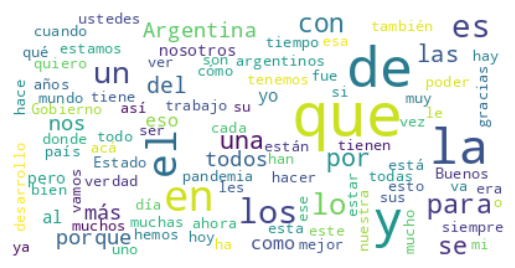

In [18]:
generate_wordcloud(df_af["speech"])

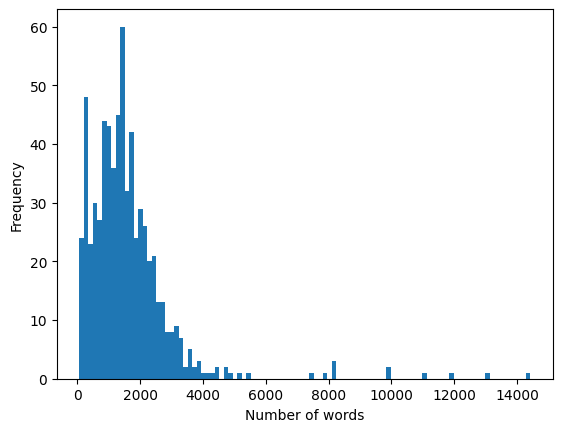

In [19]:
df_af["speech_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [20]:
df_af["speech_length"].describe()

count      665.000000
mean      1623.535338
std       1446.114435
min         73.000000
25%        859.000000
50%       1396.000000
75%       2030.000000
max      14422.000000
Name: speech_length, dtype: float64

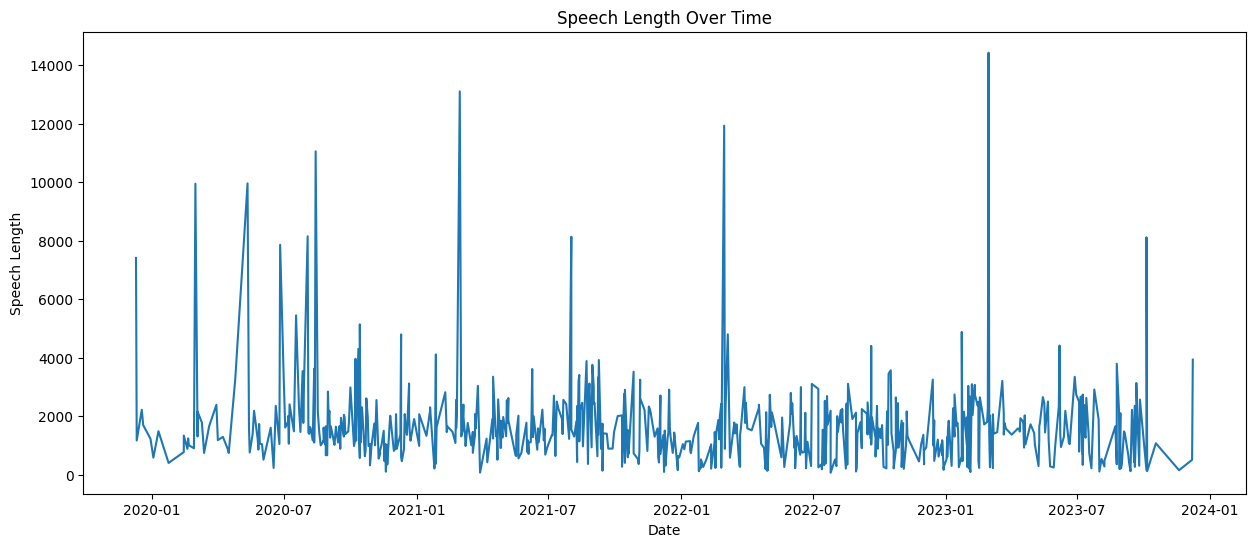

In [21]:
plt.figure(figsize=(15, 6))  # Adjust the width by changing the '15' value

plt.plot(df_af["date"], df_af["speech_length"])
plt.xlabel("Date")
plt.ylabel("Speech Length")
plt.title("Speech Length Over Time")
plt.show()

#### Preprocesamiento de texto

Realizar el preprocesamiento del texto antes de vectorizarlo con BERT puede mejorar la calidad de las representaciones y resultados en tus modelos. Aquí vemos algunos pasos comunes de preprocesamiento que podrías considerar:

* Eliminación de caracteres especiales y puntuación innecesaria.
* Conversión a minúsculas.
* Eliminación de stopwords (aunque BERT maneja bien las stopwords, eliminarlas puede ser útil dependiendo de la tarea).
* Lematización o stemming (opcional, ya que BERT maneja el contexto, pero puede ser útil en ciertos casos).

In [22]:
df_af["summary"] = df_af["speech"].apply(preprocesar)
df_af["summary_length"] = df_af["summary"].str.split().str.len()

In [23]:
df_af.head()

,speech,date,speech_length,summary,summary_length
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputada diputado senado...,3167
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noche argentino linda noche tú cuánto querer l...,379
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,día tarde mediodir gracias invitación oportuno...,765
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolo romper él diputado dejar dormir noch...,551
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedir él disculpa tardé argent...,465


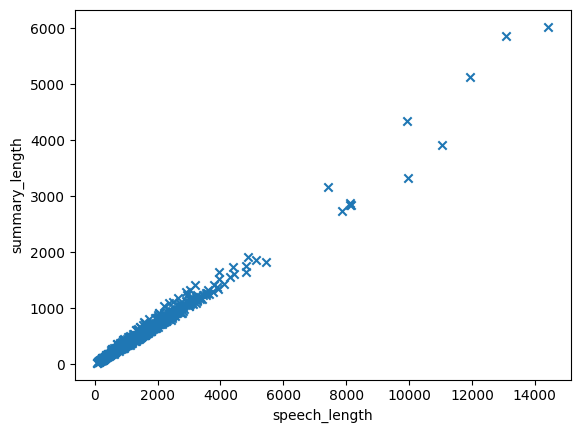

In [24]:
plt.scatter(df_af["speech_length"], df_af["summary_length"], marker="x")
plt.xlabel("speech_length")
plt.ylabel("summary_length")
plt.show()

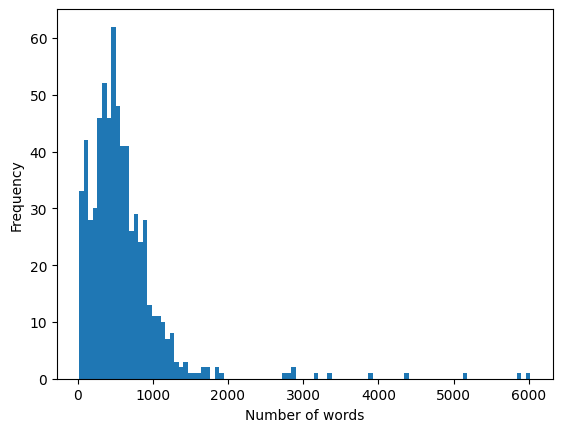

In [25]:
df_af["summary_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [26]:
df_af["summary_length"].describe()

count     665.000000
mean      598.076692
std       565.589293
min        24.000000
25%       307.000000
50%       495.000000
75%       746.000000
max      6022.000000
Name: summary_length, dtype: float64

In [27]:
summaries = " ".join(df_af["summary"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(summaries.split())}")
words_summaries = Counter(summaries.split())
words_summaries.most_common(10)

Total words in speech: 397721


[('argentino', 8364),
 ('él', 4968),
 ('país', 3201),
 ('año', 3196),
 ('día', 2919),
 ('decir', 2767),
 ('mundo', 2233),
 ('gracias', 2041),
 ('querer', 2002),
 ('seguir', 1862)]

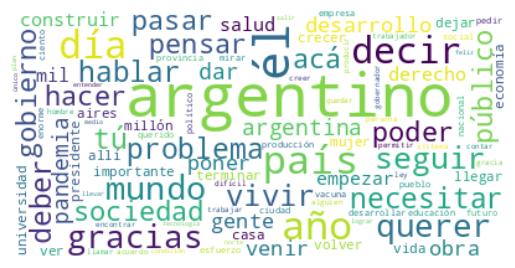

In [28]:
generate_wordcloud(df_af["summary"])

#### Vectorización de textos por BERT

In [29]:
# Cargar el tokenizador y el modelo preentrenado de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/home/pdconte/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
# Vectorizar los textos en el dataset
df_af['embeddings'] = df_af['speech'].apply(vectorize_text)

In [31]:
df_af

,speech,date,speech_length,summary,summary_length,embeddings
451,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputada diputado senado...,3167,"[[-0.47656015, 0.2589609, 0.2504023, 0.6537526..."
306,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noche argentino linda noche tú cuánto querer l...,379,"[[-0.6729181, 0.24260141, 0.19389741, 0.410149..."
271,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,día tarde mediodir gracias invitación oportuno...,765,"[[-0.5520732, 0.2675147, 0.3913604, 0.471252, ..."
154,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolo romper él diputado dejar dormir noch...,551,"[[-0.5098067, 0.16290727, 0.40687945, 0.286885..."
617,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedir él disculpa tardé argent...,465,"[[-0.43202794, 0.3239327, 0.3392792, 0.4196144..."
...,...,...,...,...,...,...
632,"Bueno, antes que nada, buenos días: bienvenido...",2023-10-06,127,día bienvenido alegría tenerlos patria tú arge...,42,"[[-0.2570137, 0.29334763, -0.0880111, 0.103550..."
146,Señor presidente de la República Popular China...,2023-10-18,1079,señor presidente república popular chino presi...,479,"[[-0.26931763, 0.0914959, 0.36197054, 0.580652..."
260,"Buen día a todos y todas, gracias por estar a...",2023-11-19,159,día gracias día argentino votar decidir futuro...,49,"[[-0.69843477, 0.031108111, 0.0939006, 0.17813..."
262,"Señor presidente; querido amigo “Lucho”, mi qu...",2023-12-07,514,señor presidente querido amigo lucho queridísi...,193,"[[-0.6688688, 0.22606204, 0.21597585, 0.297651..."


Este código vectoriza los textos del dataset utilizando el modelo BERT, generando una representación en vector para cada discurso. Los encajes pueden ser utilizados para diversas tareas de procesamiento de lenguaje natural como clasificación, análisis de sentimientos, entre otros.

Explicación de los pasos:

* Instalación de bibliotecas: transformers es la biblioteca principal que contiene el modelo y el tokenizador BERT. torch es necesario para manejar los tensores.
* Carga del dataset: Utilizamos un ejemplo simple de un DataFrame de Pandas para simular tu dataset.
* Carga del modelo y tokenizador: BertTokenizer convierte el texto en tokens que BERT puede entender, y BertModel es el modelo preentrenado de BERT.
* Tokenización y generación de encajes: Convertimos el texto en tensores, los pasamos por BERT y extraemos los encajes del token [CLS].
* Aplicación de la vectorización: Aplicamos la función vectorize_text a cada discurso en el dataset y almacenamos los encajes en una nueva columna.

Con estos pasos, los textos estarán vectorizados y listos para ser utilizados en cualquier tarea de ML.

In [32]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

Veamos cuales son los discursos que mas se parecen utilizando la similtud del coseno

In [33]:
# Convertir los embeddings de listas a arrays de numpy
df_af['embeddings'] = df_af['embeddings'].apply(lambda x: np.array(x))

In [34]:
# Crear una matriz de embeddings
embeddings_matrix = np.vstack(df_af['embeddings'].values)

In [35]:
# Calcular la similitud coseno entre todos los embeddings
similarity_matrix = cosine_similarity(embeddings_matrix)

In [36]:
# Encontrar los pares más similares
similarity_df = pd.DataFrame(similarity_matrix)

In [37]:
# Crear una lista para almacenar las similitudes
similarities = []

In [38]:
# Iterar sobre la matriz de similitudes y almacenar los pares más similares
for i in range(similarity_df.shape[0]):
    for j in range(i + 1, similarity_df.shape[1]):
        similarities.append((i, j, similarity_df.iloc[i, j]))

In [39]:
# Ordenar la lista de similitudes en orden descendente
similarities = sorted(similarities, key=lambda x: x[2], reverse=True)

In [40]:
# Obtener los 20 pares más similares
top_20_similarities = similarities[:20]

In [41]:
# Imprimir los resultados
print("Top 20 pares de textos más similares:")
for i, (idx1, idx2, sim) in enumerate(top_20_similarities, start=1):
    print(f"{i}. Texto {idx1} y Texto {idx2} - Similitud: {sim:.4f}")
    # print(f"   Texto {idx1}: {df_af.iloc[idx1]['speech']}")
    # print(f"   Texto {idx2}: {df_af.iloc[idx2]['speech']}")

Top 20 pares de textos más similares:
1. Texto 284 y Texto 285 - Similitud: 1.0000
2. Texto 297 y Texto 298 - Similitud: 1.0000
3. Texto 388 y Texto 391 - Similitud: 1.0000
4. Texto 223 y Texto 224 - Similitud: 1.0000
5. Texto 463 y Texto 464 - Similitud: 1.0000
6. Texto 574 y Texto 575 - Similitud: 1.0000
7. Texto 574 y Texto 576 - Similitud: 1.0000
8. Texto 575 y Texto 576 - Similitud: 1.0000
9. Texto 658 y Texto 662 - Similitud: 1.0000
10. Texto 369 y Texto 370 - Similitud: 1.0000
11. Texto 203 y Texto 204 - Similitud: 1.0000
12. Texto 396 y Texto 449 - Similitud: 1.0000
13. Texto 17 y Texto 278 - Similitud: 0.9875
14. Texto 53 y Texto 149 - Similitud: 0.9869
15. Texto 52 y Texto 249 - Similitud: 0.9862
16. Texto 53 y Texto 249 - Similitud: 0.9857
17. Texto 124 y Texto 128 - Similitud: 0.9857
18. Texto 259 y Texto 619 - Similitud: 0.9855
19. Texto 292 y Texto 594 - Similitud: 0.9853
20. Texto 10 y Texto 77 - Similitud: 0.9852


Ejercicio:

* Realizar el mismo procedimiento pero sin preprocesar el texto. Qué sucede? Los resultados en la similitud son iguales?

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)